In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
import dill
import featuretools as ft
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyod.models.copod import COPOD

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

#### Used only for saving/loading session variables.

In [13]:
#dill.dump_session("session.db")

In [3]:
#dill.load_session("session.db")

In [31]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_submission = pd.DataFrame({"User_ID" : data_test["User_ID"], "Product_ID" : data_test["Product_ID"]})
data_train.drop(["User_ID", "Product_ID"], axis=1, inplace=True)
data_test.drop(["User_ID", "Product_ID"], axis=1, inplace=True)
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [32]:
data_train.shape

(550068, 10)

In [33]:
print(f"""Train NaN: 
{data_train.isnull().mean() * 100}

Test NaN: 
{data_test.isnull().mean() * 100}""")

Train NaN: 
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

Test NaN: 
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            30.969311
Product_Category_3            69.590195
dtype: float64


In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          376430 non-null  float64
 8   Product_Category_3          166821 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


In [35]:
data_train = data_train.fillna(0.0).astype("object")
data_test = data_test.fillna(0.0).astype("object")
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [36]:
y = data_train.pop("Purchase")

In [39]:
cat_cols = list(data_train.select_dtypes(include="object"))
oe = OrdinalEncoder()
for col in cat_cols:
    data_train[col] = oe.fit_transform(data_train[col].values.reshape(-1, 1))
    data_test[col] = oe.transform(data_test[col].values.reshape(-1, 1))
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,0.0,0.0,10.0,0.0,2.0,0.0,2.0,0.0,0.0
1,0.0,0.0,10.0,0.0,2.0,0.0,0.0,5.0,11.0
2,0.0,0.0,10.0,0.0,2.0,0.0,11.0,0.0,0.0
3,0.0,0.0,10.0,0.0,2.0,0.0,11.0,13.0,0.0
4,1.0,6.0,16.0,2.0,4.0,0.0,7.0,0.0,0.0


In [40]:
def comb_prod_cat(df):
    prod_cats = ["Product_Category_1", "Product_Category_2", "Product_Category_3"]
    df["Total_Category"] = df[prod_cats[0]] + df[prod_cats[1]] + df[prod_cats[2]]
    return df.drop(prod_cats, axis=1)

In [41]:
data_train = comb_prod_cat(data_train)
data_test = comb_prod_cat(data_test)
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Total_Category
0,0.0,0.0,10.0,0.0,2.0,0.0,2.0
1,0.0,0.0,10.0,0.0,2.0,0.0,16.0
2,0.0,0.0,10.0,0.0,2.0,0.0,11.0
3,0.0,0.0,10.0,0.0,2.0,0.0,24.0
4,1.0,6.0,16.0,2.0,4.0,0.0,7.0


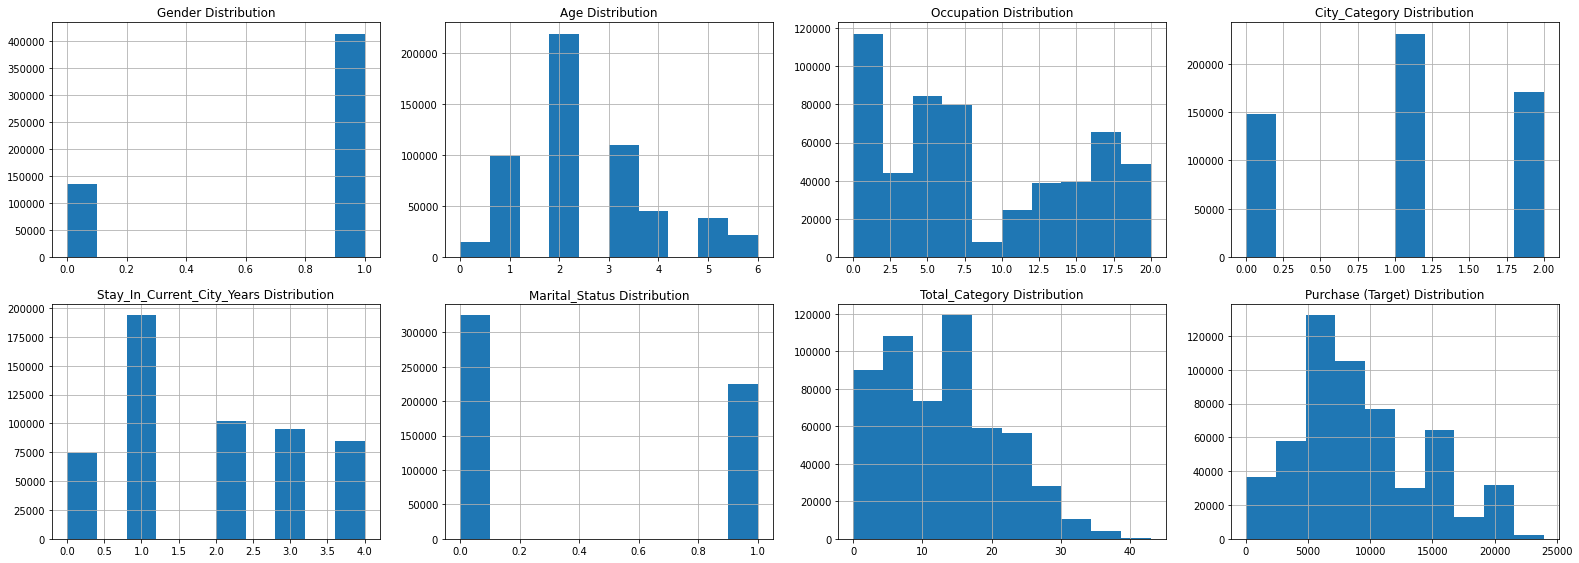

In [42]:
fig, axes = plt.subplots(2, 4, figsize=(27, 9.5))
r_idx = 0
c_idx = 0
for col in data_train:
    axes[r_idx][c_idx].set_title(f"{col} Distribution")
    data_train[col].hist(ax=axes[r_idx][c_idx])
    c_idx += 1
    if c_idx >= 4:
        r_idx += 1
        c_idx = 0
axes[r_idx][c_idx].set_title("Purchase (Target) Distribution")
axes[1][3] = y.hist(ax=axes[1][3])

In [76]:
mm = MinMaxScaler()
data_train_scaled = pd.DataFrame(data=mm.fit_transform(data_train), columns=data_train.columns)
data_test_scaled = pd.DataFrame(data=mm.transform(data_test), columns=data_test.columns)

In [45]:
umap_model = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.01, n_jobs=-1, init="random", random_state=0)
data_umap = umap_model.fit_transform(data_train_scaled)

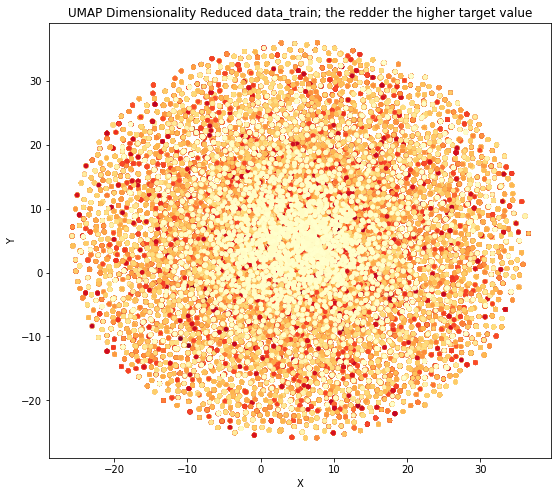

In [46]:
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("UMAP Dimensionality Reduced data_train; the redder the higher target value")
ax.scatter(data_umap[:,0], data_umap[:,1], c=y, marker=".", linewidths=1.75, cmap="YlOrRd")

In [52]:
vif_factors = [variance_inflation_factor(data_train_scaled.values, i) for i in range(data_train_scaled.shape[1])]

<AxesSubplot:title={'center':'Variance Inflation Factor (Multicollinearity)'}, xlabel='Feature'>

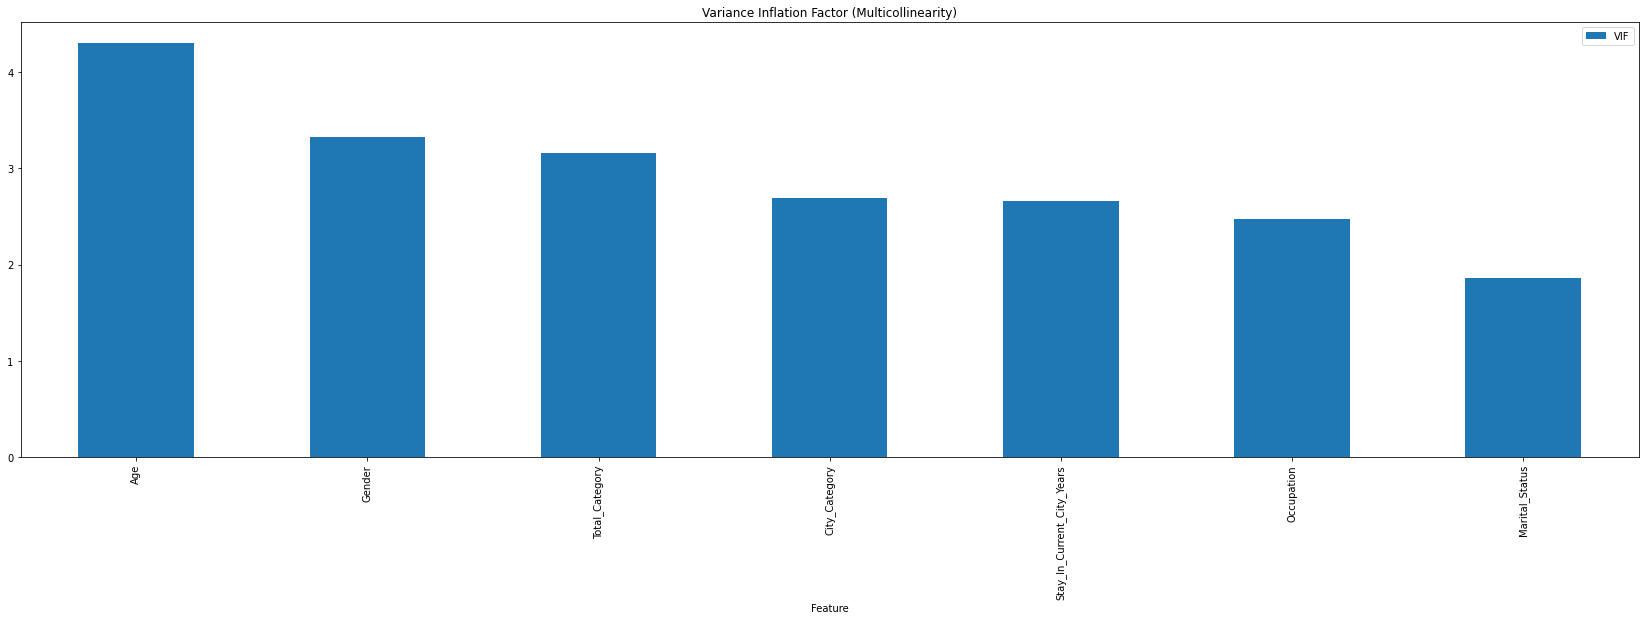

In [53]:
fig, ax = plt.subplots(figsize=(29, 8))
ax.set_title("Variance Inflation Factor (Multicollinearity)")
pd.DataFrame({"Feature" : data_train.columns, "VIF" : vif_factors}).sort_values(by="VIF", ascending=False).plot.bar(x="Feature", y="VIF", ax=ax)

In [69]:
out_model = COPOD(contamination=0.01, n_jobs=-1)
out_model.fit(data_train)
out_indices = np.argwhere(out_model.labels_ == 1)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.5s finished


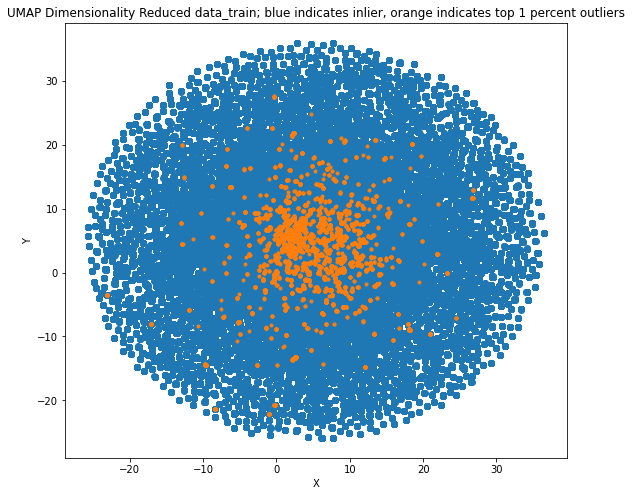

In [70]:
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("UMAP Dimensionality Reduced data_train; blue indicates inlier, orange indicates top 1 percent outliers")
ax.scatter(data_umap[:,0], data_umap[:,1], marker="o", linewidths=1)
ax.scatter(data_umap[:,0][out_indices], data_umap[:,1][out_indices], marker=".", linewidths=1, cmap="YlOrRd")

<AxesSubplot:xlabel='Outlier Score', ylabel='Count'>

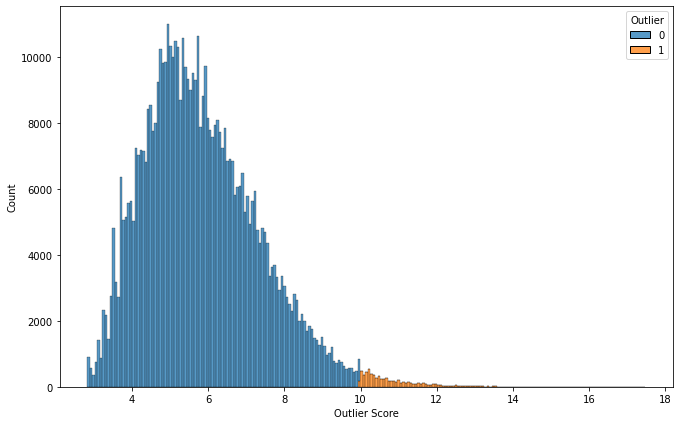

In [71]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.histplot(pd.DataFrame({"Outlier Score" : out_model.decision_scores_, "Outlier" : out_model.labels_}), x="Outlier Score", hue="Outlier", bins=225, multiple="stack", ax=ax)

In [72]:
drop_idx = data_train.index[out_indices.flatten()]
data_train_cleaned = data_train.drop(drop_idx, axis=0) # Remove top outliers
data_train_cleaned = data_train_cleaned.reset_index(drop=True)
y = y.drop(drop_idx, axis=0).astype("float64")

In [118]:
data_train_cleaned["ID"] = pd.Series(np.arange(0, data_train_cleaned.shape[0]))
data_test_scaled["ID"] = pd.Series(np.arange(0, data_test_scaled.shape[0]))
es = ft.EntitySet(id="sales")
es = es.entity_from_dataframe(entity_id="sales", dataframe=data_train_cleaned, index="ID")
es

Entityset: sales
  Entities:
    sales [Rows: 542917, Columns: 8]
  Relationships:
    No relationships

In [119]:
primitives = ft.list_primitives()
agg_num_arr = ((primitives["type"] == "aggregation") & (primitives["valid_inputs"] == "Numeric"))
trans_num_arr = ((primitives["type"] == "transform") & (primitives["valid_inputs"] == "Numeric"))
num_agg_prim = list(primitives[agg_num_arr]["name"]) # Aggregation primitives whose valid input is numeric
num_trans_prim = list(primitives[trans_num_arr]["name"]) # Transform primitives whose valid input is numeric

In [11]:
features_train, feat_names_train = ft.dfs(entityset=es, target_entity="sales", agg_primitives=num_agg_prim, trans_primitives=num_trans_prim, max_depth=1, max_features=500)
features_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
features_test, feat_names_train = ft.dfs(entityset=es, target_entity="sales", agg_primitives=num_agg_prim, trans_primitives=num_trans_prim, max_depth=1, max_features=500)
features_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
ii = IterativeImputer(estimator=lgb.LGBMRegressor(num_iterations=10, learning_rate=0.2, max_depth=6, num_leaves=255, random_state=0))
features_train = pd.DataFrame(data=ii.fit_transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(data=ii.transform(features_test), columns=features_test.columns)

In [44]:
mm = MinMaxScaler()
features_train_scaled = pd.DataFrame(data=mm.fit_transform(features_train), columns=features_train.columns)
features_test_scaled = pd.DataFrame(data=mm.transform(features_test), columns=features_test.columns)

In [45]:
lgbm_feature_importance = lgb.LGBMRegressor(num_iterations=200, learning_rate=0.05, max_depth=6, num_leaves=255, random_state=0)
lgbm_feature_importance.fit(features_train_scaled, y)

LGBMRegressor(learning_rate=0.05, max_depth=6, num_iterations=200,
              num_leaves=255, random_state=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

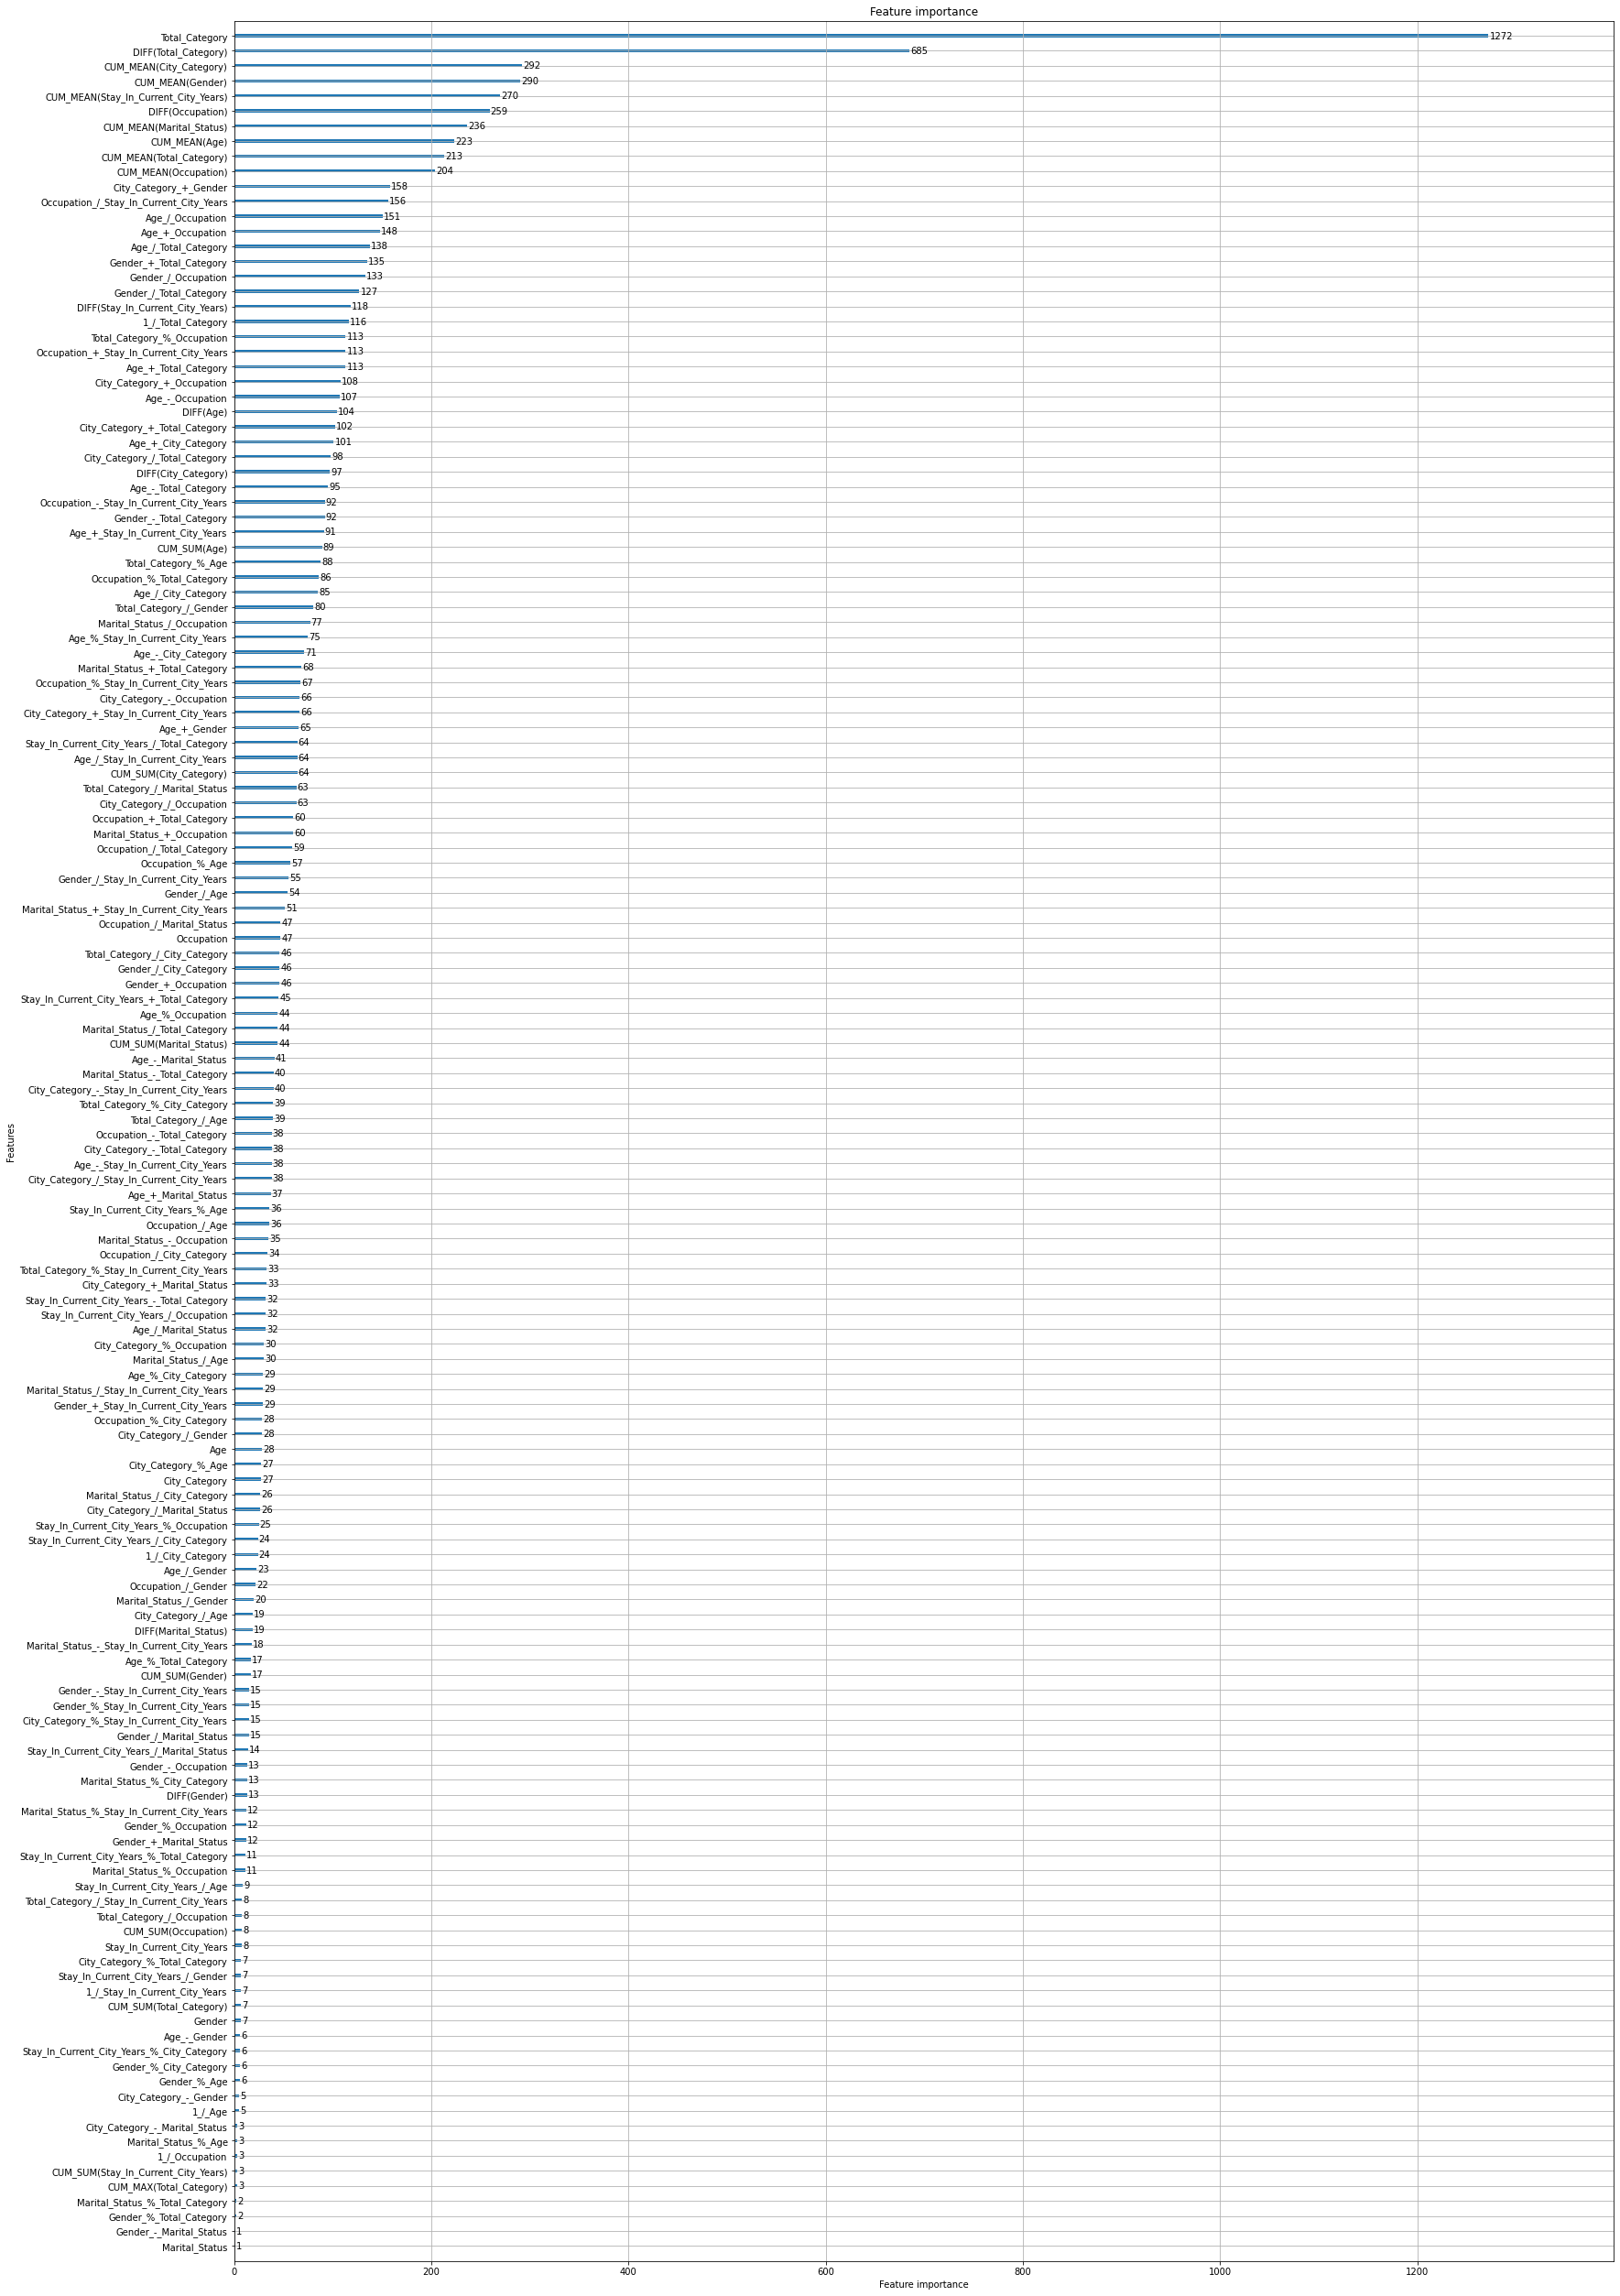

In [46]:
fig, ax = plt.subplots(figsize=(27, 45))
lgb.plot_importance(lgbm_feature_importance, ax=ax)

In [89]:
ee_feature_importance = ElasticNet(random_state=0)
ee_feature_importance.fit(features_train_scaled, y)

ElasticNet(random_state=0)

<AxesSubplot:title={'center':'Feature importance'}>

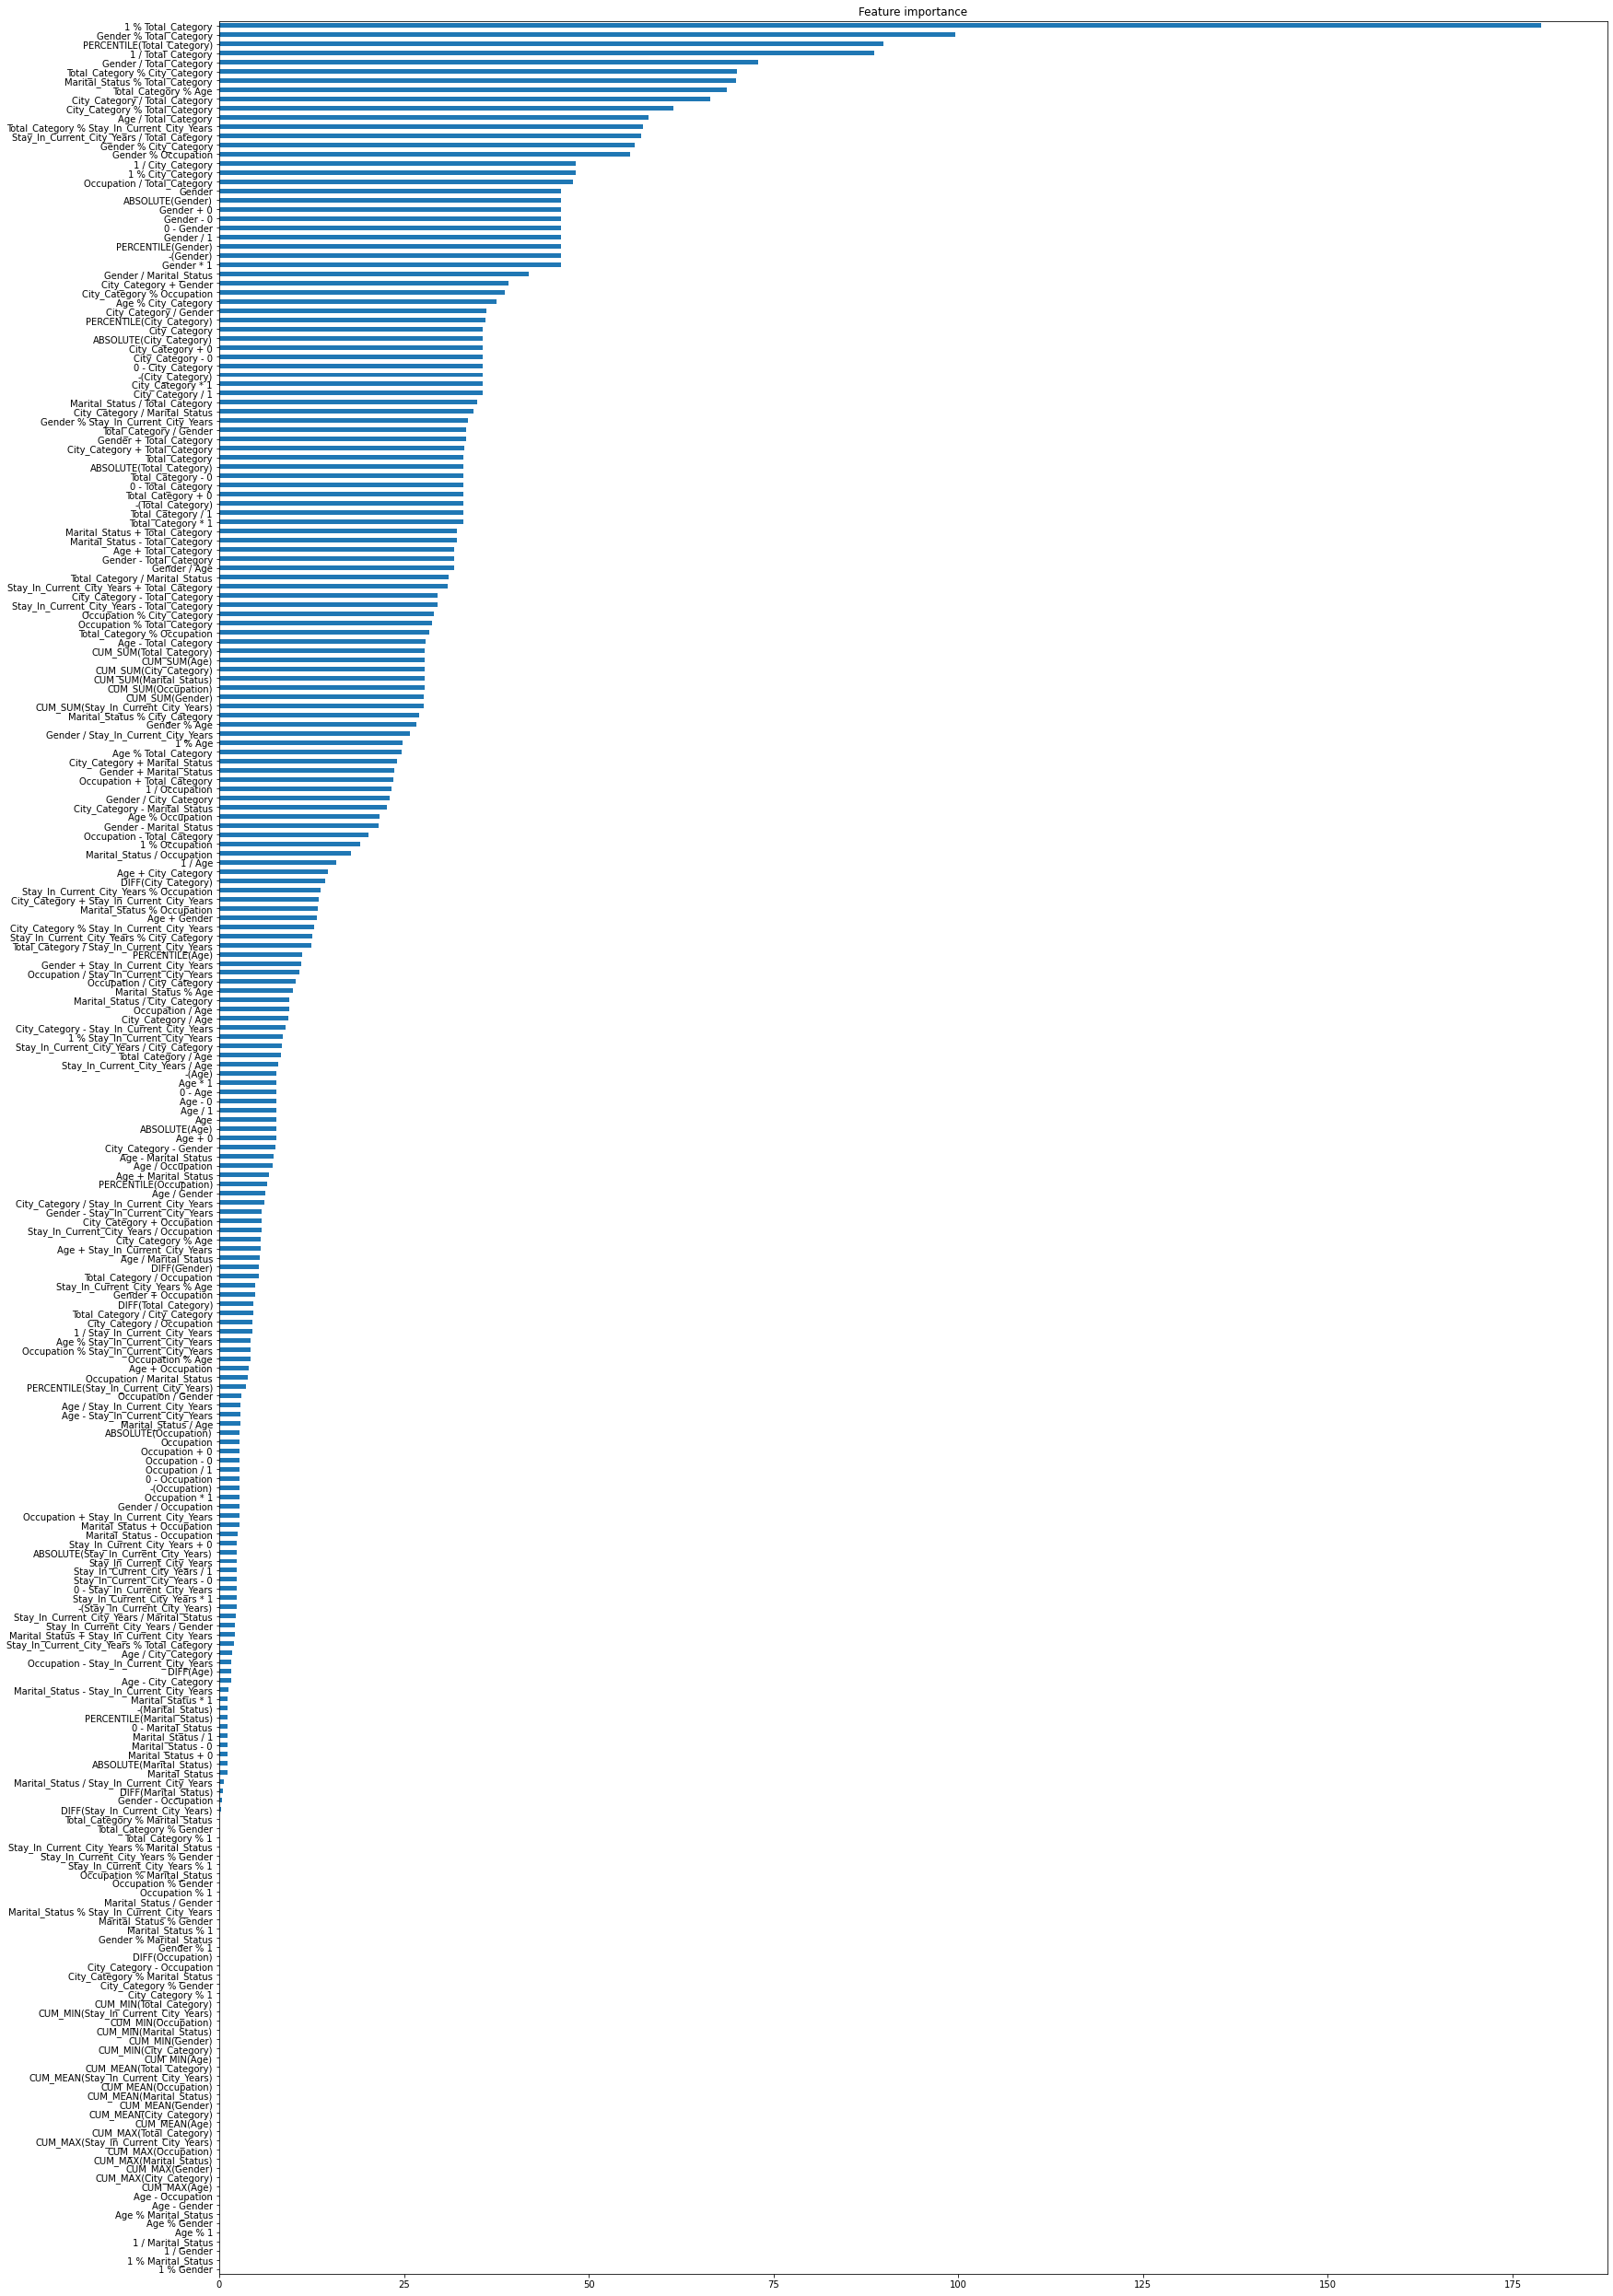

In [90]:
fig, ax = plt.subplots(figsize=(27, 45))
ax.set_title("Feature importance")
list_coef, list_cols = [list(tuple) for tuple in zip(*sorted(zip(np.abs(ee_feature_importance.coef_), features_train_scaled.columns), reverse=False))]
pd.Series(data=list_coef, index=list_cols).plot.barh(ax=ax)

<AxesSubplot:title={'center':'Feature importance (LGBM feature importance and ElasticNet averaged)'}>

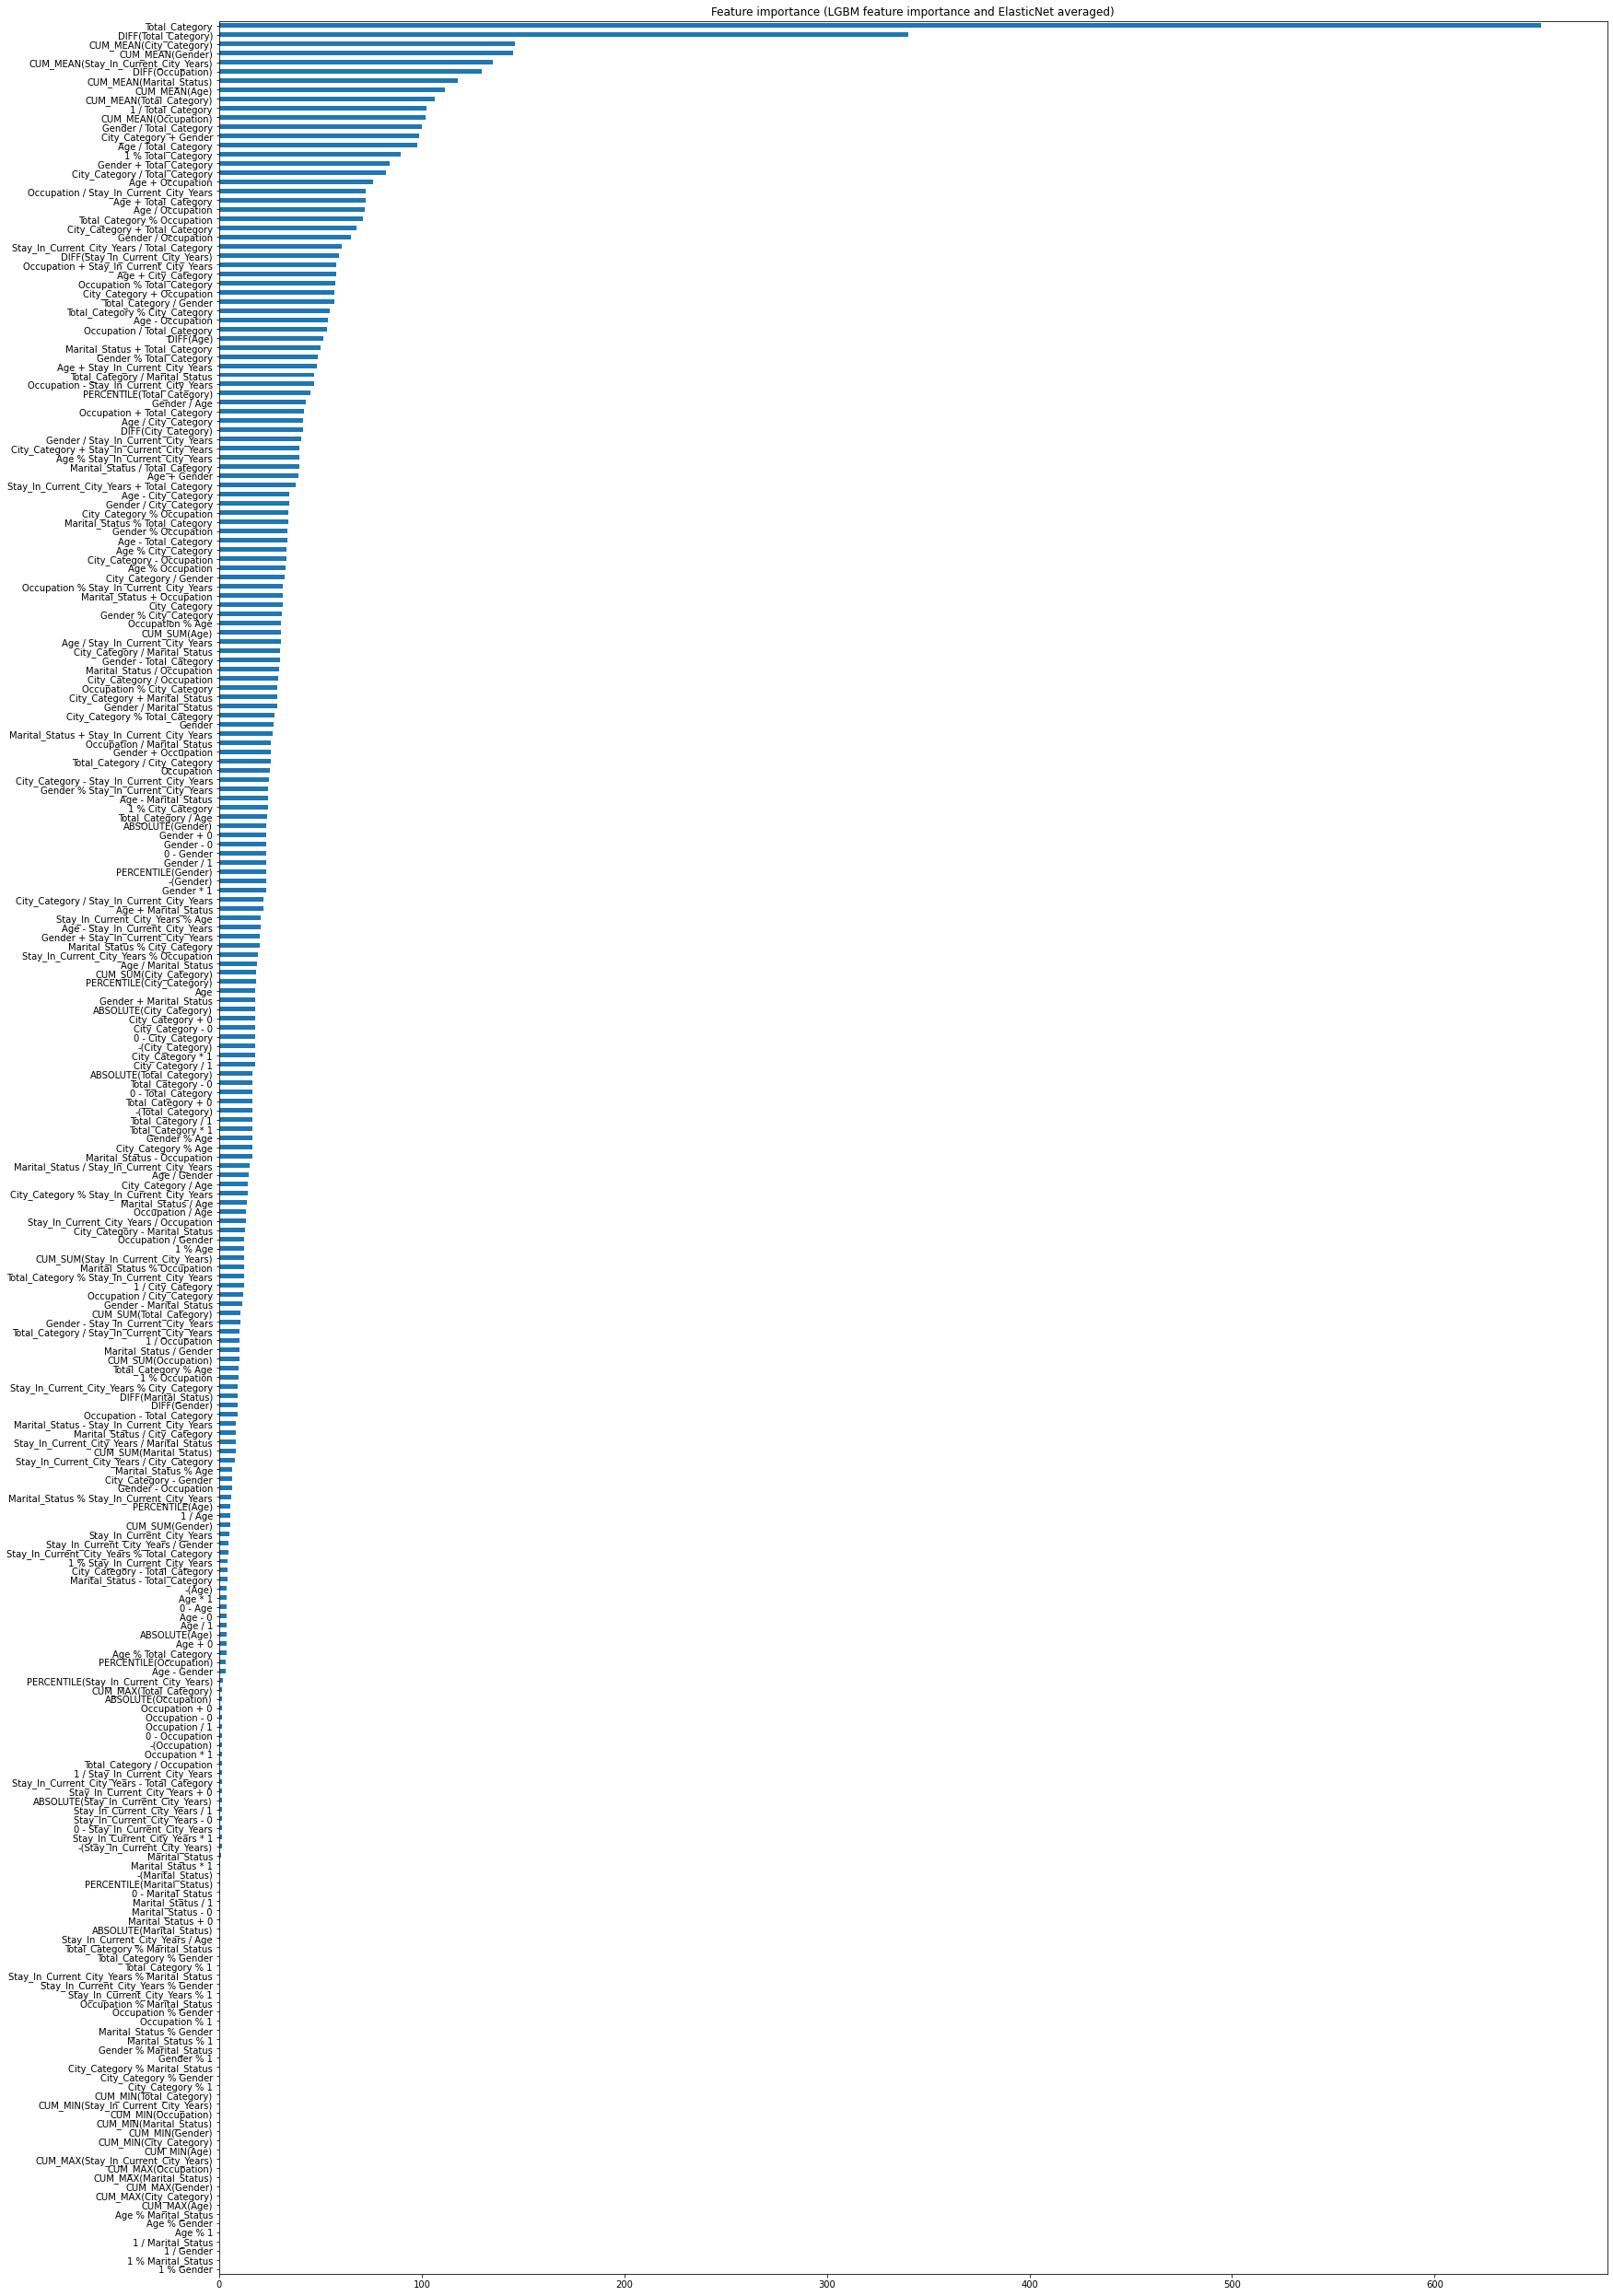

In [127]:
feat_imp_combined = (np.abs((lgbm_feature_importance.feature_importances_ + ee_feature_importance.coef_)) / 2).flatten()
fig, ax = plt.subplots(figsize=(27, 45))
ax.set_title("Feature importance (LGBM feature importance and ElasticNet averaged)")
list_coef, list_cols = [list(tuple) for tuple in zip(*sorted(zip(feat_imp_combined, features_train_scaled.columns), reverse=False))]
pd.Series(data=list_coef, index=list_cols).plot.barh(ax=ax)

In [9]:
lgbm_baseline_scores = cross_val_score(estimator=lgb.LGBMRegressor(num_iterations=100, learning_rate=0.05, max_depth=6, num_leaves=255, random_state=0, n_jobs=-1), X=features_train_scaled, y=y, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1)

In [11]:
np.mean(lgbm_baseline_scores)

-4458.794551438502